<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Modeling_C620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).dropna(axis=0)
print(c620_df.shape)
c620_df.head(3)

(15552, 420)


,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

In [3]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
y_col = sp_col + op_col
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]
for idx in n_idx:
  assert np.allclose(c620_df[y_col].iloc[:,idx].sum(axis=1),1.0) # check
print(len(x_col),len(y_col))

44 174


In [4]:
c620_df.loc[['001-002', '001-005', '001-008', '001-011', '001-014'],
            x_col+y_col].to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/Data_format_example/c620_data.xlsx')

  0%|          | 1/300 [00:00<03:46,  1.32it/s]

epoch:0 train_loss:0.0109 valid_loss:0.0022


 17%|█▋        | 51/300 [00:49<04:06,  1.01it/s]

epoch:50 train_loss:0.0003 valid_loss:0.0003


 34%|███▎      | 101/300 [01:41<03:24,  1.03s/it]

epoch:100 train_loss:0.0002 valid_loss:0.0002


 50%|█████     | 151/300 [02:33<02:41,  1.08s/it]

epoch:150 train_loss:0.0002 valid_loss:0.0002


 67%|██████▋   | 201/300 [03:28<01:54,  1.15s/it]

epoch:200 train_loss:0.0002 valid_loss:0.0002


 84%|████████▎ | 251/300 [04:31<01:04,  1.31s/it]

epoch:250 train_loss:0.0002 valid_loss:0.0002


100%|██████████| 300/300 [05:37<00:00,  1.12s/it]


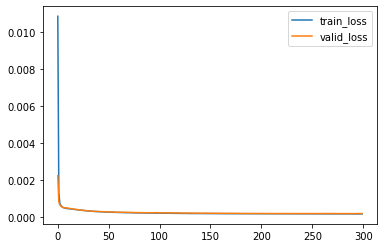

In [5]:
from autorch.utils import PartBulider
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.train()

In [6]:
c620.test(e=0.01)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,4.57999e-08,0.0119072
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0.998489,3.58734e-08,0.0115824
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0.998908,6.31502e-07,0.0500814
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0.99916,3.41687e-06,0.146499
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0.998983,1.78101e-05,0.434351
...,...,...,...
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999392,0.000727766,0.156794
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999242,0.00126036,0.182266
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999562,0.000563044,0.00990524
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.999657,0.000271232,0.00663699


In [7]:
from autorch.function import sp2wt

x_test = c620.data['X_test']
x41 = x_test[c['x41']].values
sp = c620.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [8]:
wt_real = c620_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [9]:
c620.show_metrics(wt_real,wt_pred,e=0.01).fillna(0)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.998749,1.777110e-05,0.142020
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.998826,4.132201e-03,0.109613
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.997519,8.711606e-04,0.057510
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.998872,1.265687e-03,0.301673
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999996,9.854000e-09,0.019853
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999996,1.817275e-09,0.019855
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


# 以下這兩個不能脫鉤

In [10]:
wt_pred.iloc[:,[89]].head()

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
028-091,89.946518
108-060,90.023819
090-049,70.027069
064-020,69.892136
049-043,79.903419


In [11]:
c620.data['X_test'].iloc[:,[2]].head()

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
028-091,90.000000
108-060,90.000000
090-049,70.000008
064-020,69.999985
049-043,80.000008


# 針對c620預測的wt_pred做後處理

In [12]:
def c620_wt_post_processing(wt_pred):
  def normalize(x):
    return x / x.sum(axis=1).reshape(-1,1)
  bz_idx = wt_pred.columns.tolist().index('Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%')
  other_idx = [i for i in range(41*2,41*3,1) if i != bz_idx]
  other_total = (100 - wt_pred.iloc[:,bz_idx].values).reshape(-1,1)
  wt_pred.iloc[:,other_idx] = normalize(wt_pred.iloc[:,other_idx].values)*other_total
  wt_pred.iloc[:,bz_idx] = c620.data['X_test'].iloc[:,[2]].values
  return wt_pred
wt_pred = c620_wt_post_processing(wt_pred)

# 再次確認

In [13]:
wt_pred.iloc[:,[89]].head()

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
028-091,90.000000
108-060,90.000000
090-049,70.000008
064-020,69.999985
049-043,80.000008


In [14]:
c620.data['X_test'].iloc[:,[2]].head()

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
028-091,90.000000
108-060,90.000000
090-049,70.000008
064-020,69.999985
049-043,80.000008


# 確認質量平衡

In [15]:
wt_pred.iloc[:,41*2:41*3].sum(axis=1)

028-091    100.053482
108-060     99.976181
090-049     99.972939
064-020    100.107849
049-043    100.096588
              ...    
012-108    100.025673
125-051    100.023354
023-046     99.978104
058-009    100.034744
127-093    100.307716
Length: 1556, dtype: float32

# 確認準確度

In [18]:
c620.show_metrics(wt_real,wt_pred,e=0.01).fillna(0)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.998749,1.777110e-05,0.142020
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.998826,4.132201e-03,0.109613
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.997519,8.711606e-04,0.057510
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.998872,1.265687e-03,0.301673
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999996,9.854000e-09,0.019853
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999996,1.817275e-09,0.019855
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [19]:
c620.shrink() # 節省空間

In [20]:
joblib.dump(c620,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl']